# Exercise 05 ANN for Classification - Assignment

<span style="color:red">**The submission deadline of this assignment is 09/04/2024 23:59. In addition to the executed Jupyter Notebook, please also submit the saved `.pth` file of the trained ANN on Learn.**</span>

## Pedagogy

This notebook contains both theoretical explanations and executable cells to execute your code.

When you see the <span style="color:red">**[TBC]**</span> (To Be Completed) sign, it means that you need to perform an action else besides executing the cells of code that already exist. These actions can be:
- Complete the code with proper comments
- Respond to a question
- Write an analysis
- etc.

## Requirement

In this assignment, you are required to build a multi-class classification model using ANN.

The problem to be solved is to recognize the hand-written digits:

![](https://jamesmccaffrey.files.wordpress.com/2020/10/uci_digits_0_to_9-1.jpg)

<span style="color:red">**[TBC]**</span> Please complete the following tasks:
- Build the data pipeline
- Create a multi-class classification ANN
- Train the ANN
- Save and load the trained model
- Make predictions and evaluation

### Import libraries

In [30]:
# [TBC] complete your code here with proper comments
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import torch
from torch.utils.data import TensorDataset, DataLoader
import scipy.sparse as sp

import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Task 1. Build the data pipeline

The hand-written digits dataset contains images of hand-written digits: 10 classes where each class refers to a digit. Find more details in this [link](https://scikit-learn.org/stable/datasets/toy_dataset.html#digits-dataset).
- Each hand-written digit image contains $8\times8$ pixels, which has already been converted to an 1D array with 64 features, each feature represent the value of a pixel.
- If you want to display the image, you need to re-converted the 1D array back to the 2D array ($8\times8$) with `reshape()` and display with `plt.imshow()`.

<span style="color:red">**[TBC]**</span> You need to:
- Use `sklearn.datasets.load_digits()` to load the hand-written digits dataset
- Pre-process the dataset
    - Scale numerical features with [standard scaling](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)
    - encode categorical label with [one-hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)
- Divide the dataset into the training, valiation, and test set
- Create `TensorDataset` instances to store the dataset
- Create `DataLoader` instance to wrap the dataset as iterable objects
    - Decide a proper batch size considering
        - The available memory of your computer
        - The desired number of batches in each epoch

In [14]:
# [TBC] complete your code here with proper comments
# Step 1: Load the dataset
digits = load_digits()
X, y = digits.data, digits.target

# Step 2: Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [15]:
# Step 3: Encode the labels
encoder = OneHotEncoder(sparse_output=False)
y_one_hot = encoder.fit_transform(y.reshape(-1, 1))

In [16]:
# Step 4: Split the dataset
X_train_val, X_test, y_train_val, y_test = train_test_split(X_scaled, y_one_hot, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2


In [17]:
# Step 5: Convert the numpy arrays to torch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)


In [18]:
# Step 6: Create TensorDataset instances
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)


In [19]:
# Step 7: Create DataLoader instances
batch_size = 64  # Adjust batch size as necessary
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Task 2. Create a multi-class classification ANN

<span style="color:red">**[TBC]**</span> You need to:
- Create a custom class to define the structure of the network
    - Include batch normalization layers
    - Include dropout layers
- Create an instance of this class as the ANN

In [22]:
# [TBC] complete your code here with proper comments
class MultiClassClassificationANN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_rate=0.5):
        super(MultiClassClassificationANN, self).__init__()

        # Define the architecture of the network
        self.layer1 = nn.Linear(input_size, hidden_size)  # Input layer to first hidden layer
        self.batch_norm1 = nn.BatchNorm1d(hidden_size)    # Batch normalization for first hidden layer
        self.dropout1 = nn.Dropout(dropout_rate)          # Dropout layer for first hidden layer

        self.layer2 = nn.Linear(hidden_size, hidden_size) # First hidden layer to second hidden layer
        self.batch_norm2 = nn.BatchNorm1d(hidden_size)    # Batch normalization for second hidden layer
        self.dropout2 = nn.Dropout(dropout_rate)          # Dropout layer for second hidden layer

        self.layer3 = nn.Linear(hidden_size, hidden_size) # Second hidden layer to third hidden layer
        self.batch_norm3 = nn.BatchNorm1d(hidden_size)    # Batch normalization for third hidden layer
        self.dropout3 = nn.Dropout(dropout_rate)          # Dropout layer for third hidden layer

        self.output_layer = nn.Linear(hidden_size, output_size) # Last hidden layer to output layer

        # Activation function
        self.relu = nn.ReLU()

    def forward(self, x):
        # Forward pass through the network
        x = self.relu(self.batch_norm1(self.layer1(x)))
        x = self.dropout1(x)

        x = self.relu(self.batch_norm2(self.layer2(x)))
        x = self.dropout2(x)

        x = self.relu(self.batch_norm3(self.layer3(x)))
        x = self.dropout3(x)

        x = self.output_layer(x)
        return x

In [23]:
# Specify the dimensions and hyperparameters
input_size = 64  # Each image has 64 features
hidden_size = 128  # This is a hyperparameter and can be adjusted
output_size = 10   # There are 10 classes for the digits 0-9
dropout_rate = 0.5 # Dropout rate of 50%

# Create an instance of the ANN
model = MultiClassClassificationANN(input_size, hidden_size, output_size, dropout_rate)

# Print the model's architecture
print(model)

MultiClassClassificationANN(
  (layer1): Linear(in_features=64, out_features=128, bias=True)
  (batch_norm1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (layer2): Linear(in_features=128, out_features=128, bias=True)
  (batch_norm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (layer3): Linear(in_features=128, out_features=128, bias=True)
  (batch_norm3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.5, inplace=False)
  (output_layer): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
)


## Task 3. Train the ANN

<span style="color:red">**[TBC]**</span> You need to:
- Define a `train()` function
    - Implement L2 regularization
    - Implement learning rate decay
    - Implement early stopping
- Train the ANN
    - Adjust the training hyper-parameters if necessary to get a good result
- Plot the loss history of the training process
    - Batch & epoch loss on the train set
    - Batch & epoch loss on the validation set
    - Train & validation epoch loss

In [25]:
# [TBC] complete your code here with proper comments
# Define the train function
def train(model, train_loader, val_loader, epochs, optimizer, loss_function, scheduler, early_stopping_patience=10):
    best_val_loss = float('inf')
    early_stopping_counter = 0

    # To track the loss as the model trains
    train_losses = []
    val_losses = []
    avg_train_losses = []
    avg_val_losses = []

    model.train()  # Prepare model for training
    for epoch in range(epochs):
        model.train()  # Set model to training mode
        total_train_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()  # Clear the gradients
            y_pred = model(X_batch)  # Forward pass
            loss = loss_function(y_pred, y_batch)  # Compute the loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update parameters
            total_train_loss += loss.item()
            train_losses.append(loss.item())

        scheduler.step()  # Step the scheduler

        # Validation phase
        model.eval()  # Set the model to evaluation mode
        total_val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                y_pred = model(X_batch)
                loss = loss_function(y_pred, y_batch)
                total_val_loss += loss.item()
                val_losses.append(loss.item())

        # Calculate average loss over an epoch
        avg_train_loss = total_train_loss / len(train_loader)
        avg_val_loss = total_val_loss / len(val_loader)
        avg_train_losses.append(avg_train_loss)
        avg_val_losses.append(avg_val_loss)

        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= early_stopping_patience:
                print('Early stopping!')
                break

        # Print epoch loss
        print(f'Epoch {epoch+1}/{epochs} \t Training Loss: {avg_train_loss:.4f} \t Validation Loss: {avg_val_loss:.4f}')

    return model, avg_train_losses, avg_val_losses


In [26]:
# Initialize the loss function, optimizer, and learning rate scheduler
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # L2 regularization is added here as weight_decay
scheduler = StepLR(optimizer, step_size=1, gamma=0.95)  # Decay LR by 0.95 every epoch

# Train the model
epochs = 10  # Number of epochs to train for
model, train_loss_history, val_loss_history = train(model, train_loader, val_loader, epochs, optimizer, loss_function, scheduler)


Epoch 1/10 	 Training Loss: 2.2767 	 Validation Loss: 2.0863
Epoch 2/10 	 Training Loss: 1.8843 	 Validation Loss: 1.6801
Epoch 3/10 	 Training Loss: 1.6204 	 Validation Loss: 1.3191
Epoch 4/10 	 Training Loss: 1.3773 	 Validation Loss: 1.0660
Epoch 5/10 	 Training Loss: 1.1565 	 Validation Loss: 0.8964
Epoch 6/10 	 Training Loss: 1.0656 	 Validation Loss: 0.7494
Epoch 7/10 	 Training Loss: 0.9093 	 Validation Loss: 0.6319
Epoch 8/10 	 Training Loss: 0.8647 	 Validation Loss: 0.5336
Epoch 9/10 	 Training Loss: 0.7320 	 Validation Loss: 0.4754
Epoch 10/10 	 Training Loss: 0.6932 	 Validation Loss: 0.4217


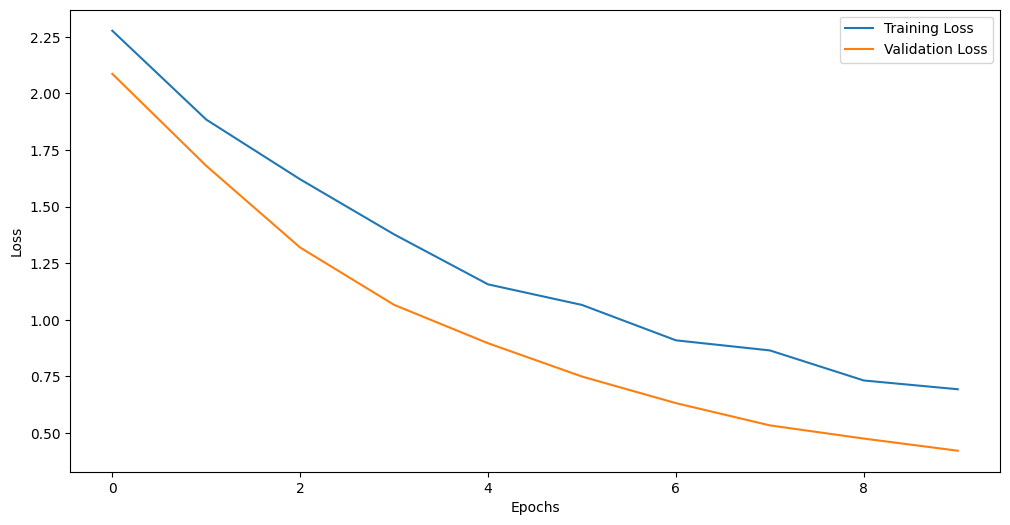

In [31]:

# Plot the loss history
plt.figure(figsize=(12, 6))
plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Task 4. Save and load the trained model

<span style="color:red">**[TBC]**</span> You need to:
- Save the trained model
    - <span style="color:red">**Don't forget to include the saved file in your submission.**</span>
- Re-create the neural network and load the saved model

In [32]:
# [TBC] complete your code here with proper comments
# Save model state dictionary
file_name = 'digit_classifier1.pth'
torch.save(model.state_dict(), file_name)
print('Saved PyTorch Model State to ' + file_name)

Saved PyTorch Model State to digit_classifier1.pth


In [33]:
# Create an instance of the ANN
model_to_load = MultiClassClassificationANN(input_size, hidden_size, output_size, dropout_rate)

# Load the saved model state dictionary
model_to_load.load_state_dict(torch.load(file_name))

# Set the model to evaluation mode
model_to_load.eval()

print('Loaded PyTorch Model State from ' + file_name)

Loaded PyTorch Model State from digit_classifier1.pth


## Task 5. Make predictions and evaluation

<span style="color:red">**[TBC]**</span> You need to:
- Define the `test()` function
    - Output logits, probabilities and predictions
    - Output the loss value on the test set
- Make predictions on the test dataset
- Evaluate the performance
    - Use `sklearn.metrics.classification_report()`

Loss on the test set: 0.4022
              precision    recall  f1-score   support

           0      1.000     1.000     1.000        33
           1      0.926     0.893     0.909        28
           2      0.939     0.939     0.939        33
           3      1.000     0.941     0.970        34
           4      1.000     0.978     0.989        46
           5      0.930     0.851     0.889        47
           6      0.971     0.971     0.971        35
           7      0.971     0.971     0.971        34
           8      0.794     0.900     0.844        30
           9      0.795     0.875     0.833        40

    accuracy                          0.931       360
   macro avg      0.933     0.932     0.932       360
weighted avg      0.934     0.931     0.932       360



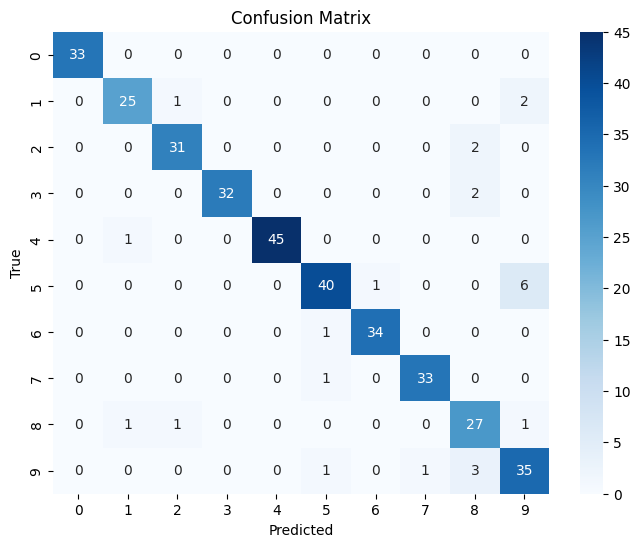

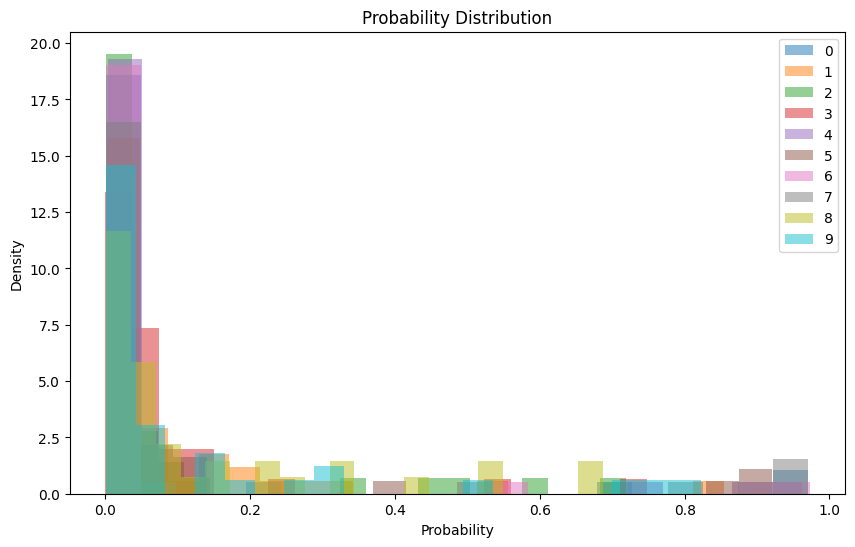

In [40]:
# [TBC] complete your code here with proper comments
from torch.nn.functional import softmax
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def test(model, test_loader, loss_function):
    model.eval()  # Set the model to evaluation mode
    all_logits = []
    all_probs = []
    all_preds = []
    all_targets = []
    test_loss = 0

    with torch.no_grad():
        for inputs, targets in test_loader:
            logits = model(inputs)
            loss = loss_function(logits, torch.max(targets, 1)[1])
            test_loss += loss.item()

            probs = softmax(logits, dim=1)
            preds = torch.max(probs, 1)[1]

            all_logits.append(logits)
            all_probs.append(probs)
            all_preds.append(preds)
            all_targets.append(targets)

    # Concatenate all batches
    all_logits = torch.cat(all_logits, dim=0)
    all_probs = torch.cat(all_probs, dim=0)
    all_preds = torch.cat(all_preds, dim=0)
    all_targets = torch.cat(all_targets, dim=0)

    # Convert targets to the same format as predictions
    all_targets = torch.max(all_targets, 1)[1]

    # Calculate average loss over all the test data
    avg_test_loss = test_loss / len(test_loader)
    print(f'Loss on the test set: {avg_test_loss:.4f}')

    # Classification report
    print(classification_report(all_targets.cpu(), all_preds.cpu(), digits=3))
    
    # Confusion Matrix
    cm = confusion_matrix(all_targets.cpu(), all_preds.cpu())
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Probability Distribution Plot
    class_names = [str(i) for i in range(10)]  # Assuming 10 classes
    plt.figure(figsize=(10, 6))
    for i in range(10):  # Assuming 10 classes
        plt.hist(probs[:, i], bins=20, alpha=0.5, label=class_names[i], density=True)
    plt.xlabel('Probability')
    plt.ylabel('Density')
    plt.title('Probability Distribution')
    plt.legend()
    plt.show()




    return all_logits, all_probs, all_preds, avg_test_loss

# Call the test function
loss_function = nn.CrossEntropyLoss()  # Recreate the loss function
logits, probs, preds, test_loss = test(model_to_load, test_loader, loss_function)